
HTPC Test:
Step 1 - L1 Error Sum: 4.86
Step 2 - L1 Error Sum: 14.49
Step 3 - L1 Error Sum: 14.46
Step 4 - L1 Error Sum: 2.93


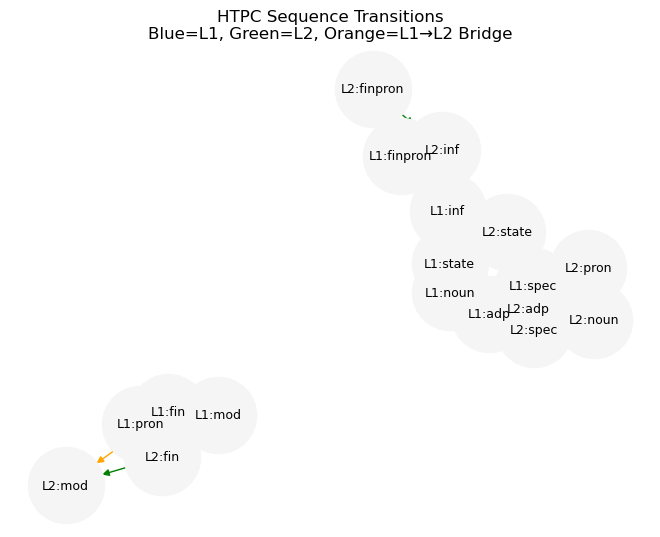

In [7]:
# HTPC Model with Hierarchical Sequence Memory and Visualization

import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt


# --- Word Encoder ---
class WordEncoder:
    def __init__(self, n_bits=512, w=21):
        self.n_bits = n_bits
        self.w = w
        self.word_to_sdr = {}

    def _create_sdr(self):
        sdr = torch.zeros(self.n_bits)
        active = torch.randperm(self.n_bits)[:self.w]
        sdr[active] = 1.0
        return sdr

    def encode(self, word):
        if word not in self.word_to_sdr:
            self.word_to_sdr[word] = self._create_sdr()
        return self.word_to_sdr[word]


def encode_sentence_to_sdr_sequence(sentence, encoder):
    words = sentence.lower().split()
    return [encoder.encode(w) for w in words]


# --- Sequence Memory ---
class SequenceMemory:
    def __init__(self):
        self.transitions = {}

    def _hash_sdr(self, sdr):
        return tuple(sdr.round().int().tolist())

    def learn_sequence(self, sdr_sequence):
        for i in range(len(sdr_sequence) - 1):
            key = self._hash_sdr(sdr_sequence[i])
            self.transitions[key] = sdr_sequence[i + 1]

    def predict_next(self, current_sdr):
        key = self._hash_sdr(current_sdr)
        return self.transitions.get(key, torch.zeros_like(current_sdr))


# --- Layer 1 HTPC Neuron ---
class HTPCNeuronLayer(nn.Module):
    def __init__(self, input_size, num_neurons, name):
        super().__init__()
        self.name = name
        self.weights = nn.Parameter(torch.randn(num_neurons, input_size) * 0.1)
        self.bias = nn.Parameter(torch.zeros(num_neurons, 1))
        self.last_input = None
        self.last_prediction = None

    def forward(self, x):
        self.last_input = x.detach()
        prediction = self.weights @ self.last_input + self.bias
        self.last_prediction = prediction
        return prediction

    def compute_error(self, actual_input):
        return actual_input.detach() - self.last_prediction

    def update_weights(self, error, learning_rate):
        with torch.no_grad():
            self.weights += learning_rate * error @ self.last_input.T
            self.bias += learning_rate * error


# --- HTPC Model with Two-Layer Sequence Memory ---
class HTPCModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = HTPCNeuronLayer(input_size=512, num_neurons=512, name="L1")
        self.memory1 = SequenceMemory()
        self.memory2 = SequenceMemory()

    def train_sequence_memory(self, sentence, encoder):
        sdr_seq = encode_sentence_to_sdr_sequence(sentence, encoder)
        self.memory1.learn_sequence(sdr_seq)

        # Learn transitions between memory1 predictions
        predictions = [self.memory1.predict_next(sdr) for sdr in sdr_seq[:-1]]
        self.memory2.learn_sequence(predictions)

    def step(self, encoded_input, next_encoded_input, learning_rate=0.01):
        encoded_input = encoded_input.view(-1, 1)
        next_encoded_input = next_encoded_input.view(-1, 1)

        # Layer 1 prediction and update
        l1_prediction = self.layer1(encoded_input)
        l1_error = self.layer1.compute_error(encoded_input)
        self.layer1.update_weights(l1_error, learning_rate)

        # Memory 1: word-to-word
        mem1_pred = self.memory1.predict_next(encoded_input.view(-1)).view(-1, 1)

        # Memory 2: transition-to-transition
        mem2_pred = self.memory2.predict_next(mem1_pred.view(-1)).view(-1, 1)

        return {
            "l1_error": l1_error.view(-1).detach().numpy(),
            "temporal_prediction": mem1_pred.view(-1).detach().numpy(),
            "hierarchical_prediction": mem2_pred.view(-1).detach().numpy()
        }


# --- Visualization ---
def visualize_sequence_memories(memory1, memory2, encoder):
    G = nx.DiGraph()

    def label_sdr(sdr, prefix):
        for word, stored in encoder.word_to_sdr.items():
            if torch.equal(sdr, stored):
                return f"{prefix}:{word}"
        return f"{prefix}:{hash(tuple(sdr.tolist())) % 10000}"

    # --- Layer 1: Word transitions ---
    for src, dst in memory1.transitions.items():
        src_tensor = torch.tensor(src).float()
        dst_tensor = dst
        G.add_edge(label_sdr(src_tensor, "L1"), label_sdr(dst_tensor, "L1"), color='blue')

        # L1 → L2 bridge edge (from L1 prediction to its representation in L2)
        predicted = memory1.predict_next(src_tensor)
        if predicted is not None:
            G.add_edge(label_sdr(src_tensor, "L1"), label_sdr(predicted, "L2"), color='orange')

    # --- Layer 2: prediction-of-prediction transitions ---
    for src, dst in memory2.transitions.items():
        src_tensor = torch.tensor(src).float()
        dst_tensor = dst
        G.add_edge(label_sdr(src_tensor, "L2"), label_sdr(dst_tensor, "L2"), color='green')

    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000,
            edge_color=edge_colors, node_color='whitesmoke', font_size=9)
    plt.title("HTPC Sequence Transitions\nBlue=L1, Green=L2, Orange=L1→L2 Bridge")
    plt.show()



# --- Example Usage ---
if __name__ == "__main__":
    encoder = WordEncoder(n_bits=512, w=21)
    model = HTPCModel(input_size=512)

    sentences = [
        "spec noun fin adp spec noun",
        "spec noun fin adp spec noun",
        "spec noun fin"
        "pron inf pron adp noun",
        "pron inf state adp inf",
        "spec noun mod fin spec noun adp spec noun",
        "pron fin mod"
    ]

    # Train the model
    for sentence in sentences:
        model.train_sequence_memory(sentence, encoder)

    # Run a test
    test_seq = encode_sentence_to_sdr_sequence("spec inf adp spec noun", encoder)
    print("\nHTPC Test:")
    for i in range(len(test_seq) - 1):
        output = model.step(test_seq[i], test_seq[i + 1])
        print(f"Step {i + 1} - L1 Error Sum: {output['l1_error'].sum():.2f}")

    # Visualize learned transitions
    visualize_sequence_memories(model.memory1, model.memory2, encoder)
